Apply fisher score matching to a Weak Lensing Example and compare to results from differential simulator `jax-cosmo`.

We assume the data likelihood is Gaussian:
$$
    x \mid \theta \sim \mathcal{N}(\mu(\theta), \Sigma_{\text{fid}}),
$$
where $x = C_{\ell}$, $\theta = (\Omega_c, \sigma_8)$, $\mu(\theta)$ is the mean spectrum computed by `jax-cosmo`, and $\Sigma_{\text{fid}}$ is a fixed covariance matrix evaluated at a fiducial cosmology.

Under this Gaussian model and using the differentiability of `jax-cosmo`, we can compute the ground truth Fisher score and Fisher information matrix as:
$$
    s^*(x, \theta) = \left( \nabla_{\theta} \mu(\theta) \right)^\top \Sigma_{fid}^{-1} (x - \mu(\theta)), \\
    \mathcal{I^*}(\theta) = \left( \nabla_{\theta} \mu(\theta) \right)^\top \Sigma_{fid}^{-1} \left( \nabla_{\theta} \mu(\theta) \right).
$$

This model is not obviously decomposable, so we introduce an auxiliary latent variable $\tilde{\theta}$. We sample $\tilde{\theta}$ from the  ranges $[0.2, 0.4]$ for $\Omega_c$ and $[0.70, 0.90]$ for $\sigma_8$. Then, we generate $\theta$ by adding Gaussian noise: $\theta \sim \mathcal{N}(\tilde{\theta}, \sigma^2 \cdot \mathbf{I})$, with $\sigma \approx 10^{-3}$. Once $\theta$ is sampled, we compute $C_\ell$ using `jax-cosmo`. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os
sys.path.append('/home/csui1/workspace/fsm/FisherScoreMatching')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#torch 
import torch
import torch.nn as nn
from fsm.models import LinearGaussianModel
from fsm.plot_utils import downsample_scatter_plot,plot_vector_field
from fsm.regressor import FSM_Regressor
from fsm.tools import to_numpy,to_tensor

### Define Cl model using jax cosmo

In [103]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

import warnings
# Suppress all warnings from 'some_package'
warnings.filterwarnings("ignore", module="jax")

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

JAX version: 0.4.30
jax-cosmo version: 0.1.0


In [104]:
from fsm.models import jax_cosmo_cl_model
from scipy import stats
def get_param_samples(n, seed,all_prior=None):
    """
    Get n samples from a latin hypercube from uniform prior
    
    Args:
        :n (int): Number of sets of cosmological samples to obtain
        :seed (int): The random seems for the latin hypercube
        
    Returns:
        :cosmo_params (np.ndarray): Array of cosmological parameters of shape (n, number of parameters).
            The parameters are ordered 10^9 As, Om, Ob, h, ns
    """

    if all_prior is None:
        all_prior = [
                    [0.2, 0.3],  # Oc
                    [0.73, 0.90],  # sigma8
                ]

    # Generate samples
    d = len(all_prior)
    lh_sampler = stats.qmc.LatinHypercube(d, seed=seed)
    cosmo_params = lh_sampler.random(n)
    for i in range(d):
        cosmo_params[:,i] = all_prior[i][0] + (all_prior[i][1] - all_prior[i][0]) * cosmo_params[:,i]
        
        
    return cosmo_params

In [105]:
cl_model_batched = jax_cosmo_cl_model(n_ell=5)

Perturb the latent parameter

In [106]:
dim = 2

all_prior = [
            [0.2, 0.4],  # Oc
            [0.70, 0.90],  # sigma8
        ]
all_prior = np.array(all_prior)

sample_size = 100000

theta_latent = to_tensor(get_param_samples(sample_size,seed = 0,all_prior=all_prior))

#perturb theta_tild 
np.random.seed(0)
epsilon_cov = np.diag((all_prior[:,1] - all_prior[:,0])/200)**2
latent_model = LinearGaussianModel(cov = epsilon_cov)
theta, latent_score = latent_model.sample_and_score(theta_latent)

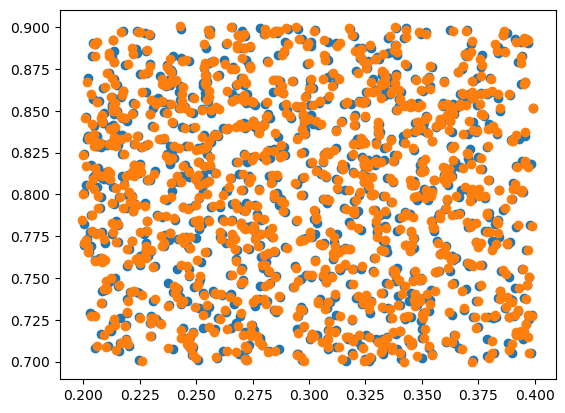

In [107]:
ax = downsample_scatter_plot(theta_latent,seed=0)
ax = downsample_scatter_plot(theta, ax=ax, seed=0)

In [108]:
theta.shape

(100000, 2)

In [109]:
n_chunk = sample_size//10000
theta_chunk = np.array_split(theta, n_chunk)
x = []
for i in range(n_chunk):
    x_i = cl_model_batched.sample(theta_chunk[i])
    x.append(x_i)
x = np.concatenate(x, axis=0)

theta = to_numpy(theta)
latent_score = to_numpy(latent_score)
x = to_numpy(x)
theta_latent = to_numpy(theta_latent)
theta.shape,theta_latent.shape,x.shape,latent_score.shape

((100000, 2), (100000, 2), (100000, 15), (100000, 2))

In [110]:
norm = np.std(latent_score, axis=0)
latent_score = latent_score / norm

In [111]:
norm

array([ 999.1894, 1001.3067], dtype=float32)

In [112]:
train_input = np.concatenate((x,theta_latent), axis=1)
train_ouput = latent_score.copy()

train_input = to_tensor(train_input)
train_ouput = to_tensor(train_ouput)

train_input.shape, train_ouput.shape

(torch.Size([100000, 17]), torch.Size([100000, 2]))

In [ ]:
activation = nn.ELU
f = nn.Sequential(
        nn.Linear(train_input.shape[1], 64),
        activation(),
        nn.Linear(64, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, train_ouput.shape[1]),             
    )

fm_regressor = FSM_Regressor(f, device='cuda')
fm_regressor.train(train_input, train_ouput, lr=1e-3, epochs=10000,verbose=True)

Plot fisher vectors at a given mock observation

In [116]:
test_theta = get_param_samples(1000, seed=1,all_prior=all_prior)

test_x = cl_model_batched.sample(test_theta)

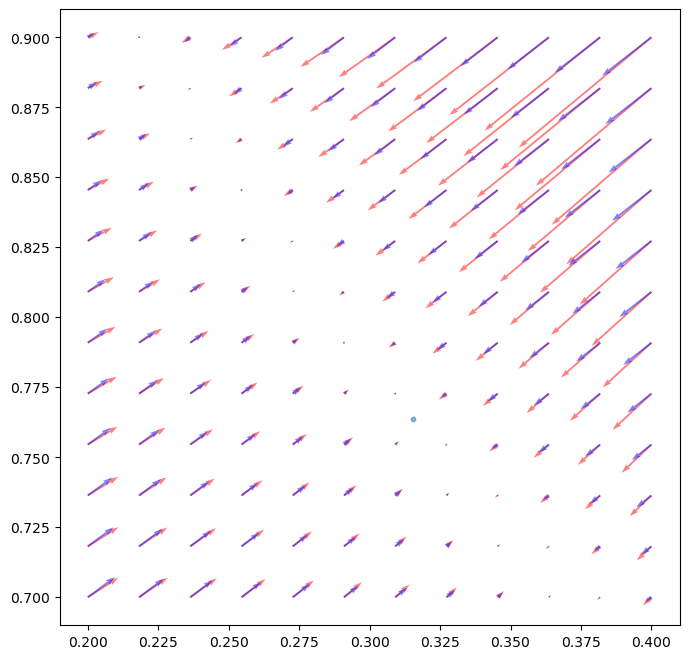

In [119]:


test_idx = np.random.randint(1000)

x_fid = test_x[test_idx]

fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range_x = all_prior[0]
plot_range_y = all_prior[1]
norm_vector = False
arrow_scale = 1e5

ax = plot_vector_field(plot_range_x,plot_range_y, 
                  lambda theta: cl_model_batched.fisher_score(x_fid, theta),
                  num_points=12,ax=ax,color='red',alpha=0.5, label='True Score', width=0.003,norm_vector=norm_vector,scale= arrow_scale)

ax = plot_vector_field(plot_range_x,plot_range_y,
                  lambda theta: (fm_regressor.cond_predict(x_fid,theta)*norm),
                  num_points=12,ax=ax,color='blue',alpha=0.5, label='Estimated Score', width=0.003,norm_vector=norm_vector,scale= arrow_scale)

ax.scatter(
    test_theta[test_idx, 0], test_theta[test_idx, 1], label='theta_fid', alpha=0.5, s=10
)

### Fisher matrix

Estimate Fisher matrix at a grid of parameters

In [120]:
from fsm.plot_utils import plot_contours

In [121]:
n_grid = 3
theta_grid = np.meshgrid(
    np.linspace(all_prior[0][0], all_prior[0][1], n_grid+2)[1:-1],
    np.linspace(all_prior[1][0], all_prior[1][1], n_grid+2)[1:-1]
)
theta_grid = np.array(theta_grid).reshape(2, -1).T
theta_grid.shape

(9, 2)

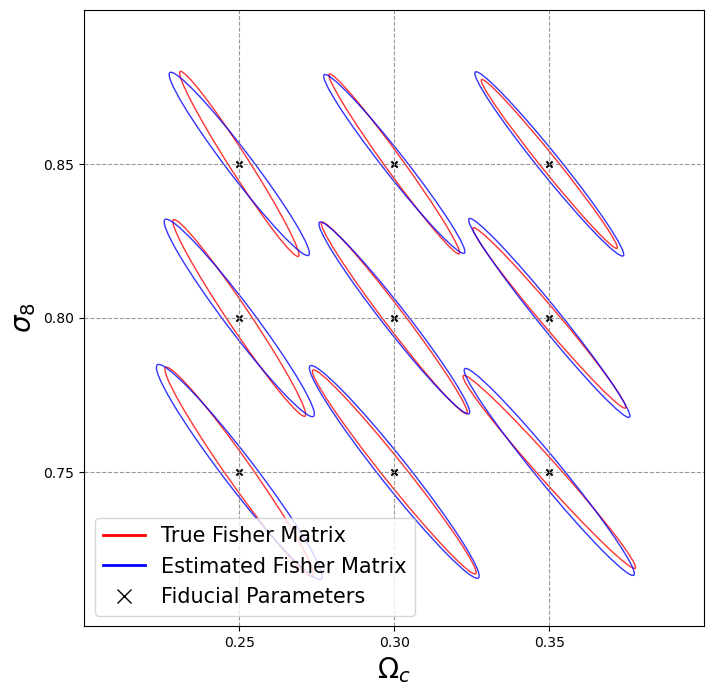

In [122]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
for theta_i in theta_grid:
    sample_size = 10000
    theta_input = np.repeat(theta_i[None,:], sample_size, axis=0)
    x_fid = cl_model_batched.sample(theta_input)
    score_est = fm_regressor.cond_predict(x_fid, theta_input)*norm

    F_true = cl_model_batched.fisher_matrix_batch(theta_i[None,:])[0]
    F_est = np.cov(score_est.T)

    ax = plot_contours(F_true, theta_i, nstd=1., ax=ax, color='red', alpha=0.8,fill=False)
    ax = plot_contours(F_est, theta_i, nstd=1., ax=ax, color='blue', alpha=0.8,fill=False)

ax.set_xlim(all_prior[0])
ax.set_ylim(all_prior[1])
x_ticks = np.linspace(all_prior[0][0], all_prior[0][1], n_grid+2)[1:-1]
y_ticks = np.linspace(all_prior[1][0], all_prior[1][1], n_grid+2)[1:-1]
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.8)
ax.scatter(theta_grid[:, 0], theta_grid[:, 1], color='black', s=20,marker='x')
ax.set_xlabel('$\Omega_c$',fontsize=20)
ax.set_ylabel('$\sigma_8$',fontsize=20)

lengend_handles = [
    plt.Line2D([0], [0], color='red', lw=2, label='True Fisher Matrix'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Estimated Fisher Matrix'),
    plt.Line2D([0], [0], color='black', marker='x',lw=0, label='Fiducial Parameters', markersize=10),
]
ax.legend(handles=lengend_handles, loc='lower left', fontsize=15)

### Inference

Run Bayesian Inference with Hamiltonian MonteCarlo

In [136]:
from fsm.samplers import HamiltonianMonteCarloSampler

In [126]:
test_idx = np.random.randint(1000)

x_fid = test_x[test_idx]
theta_fid = test_theta[test_idx]

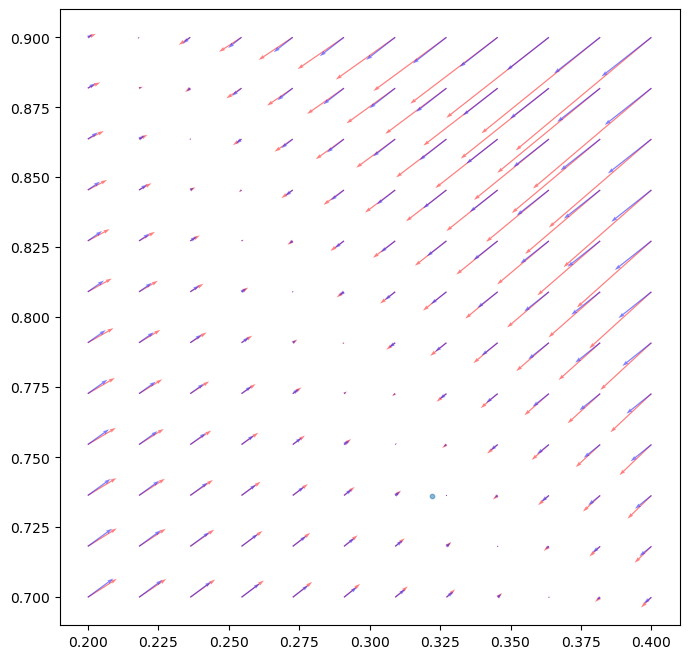

In [128]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range_x = all_prior[0]
plot_range_y = all_prior[1]
norm_vector = False
arrow_scale = 1e5

ax = plot_vector_field(plot_range_x,plot_range_y, 
                  lambda theta: cl_model_batched.fisher_score(x_fid, theta),
                  num_points=12,ax=ax,color='red',alpha=0.5, label='truth', width=0.002,norm_vector=norm_vector,scale= arrow_scale)

ax = plot_vector_field(plot_range_x,plot_range_y,
                  lambda theta: fm_regressor.cond_predict(x_fid,theta)*norm,
                  num_points=12,ax=ax,color='blue',alpha=0.5, label='regressor', width=0.002,norm_vector=norm_vector,scale= arrow_scale)
ax.scatter(
    theta_fid[0], theta_fid[1], label='theta_fid', alpha=0.5, s=10
)

In [141]:
score_func_fsm = lambda theta: (fm_regressor.cond_predict(x_fid,theta)*norm)[0]
score_func_model =lambda theta: cl_model_batched.fisher_score(x_fid, theta[None])[0]

In [143]:
sampler = HamiltonianMonteCarloSampler(score_func_fsm, momentum_cov=np.eye(2)*1e-1,prior=all_prior)
init_sample = np.array([0.25, 0.8])
num_samples = 10000
samples, acceptance_rate = sampler.sample(
    num_samples=num_samples,
    initial_states=init_sample,
    leapfrog_steps=10,
    leapfrog_step_size=1e-4,
    save_trajectory=False
)
print(f"Acceptance rate: {acceptance_rate}")

Acceptance rate: [0.9985]


In [153]:
sampler = HamiltonianMonteCarloSampler(score_func_model, momentum_cov=np.eye(2)*1e-1,prior=all_prior)
init_sample = np.array([0.25, 0.8])
num_samples = 10000
samples_truth, acceptance_rate = sampler.sample(
    num_samples=num_samples,
    initial_states=init_sample,
    leapfrog_steps=10,
    leapfrog_step_size=1e-4,
    save_trajectory=False
)
print(f"Acceptance rate: {acceptance_rate}")

Acceptance rate: [0.9996]


In [145]:
samples = samples.reshape(-1, 2)

In [154]:
samples_truth = samples_truth.reshape(-1, 2)

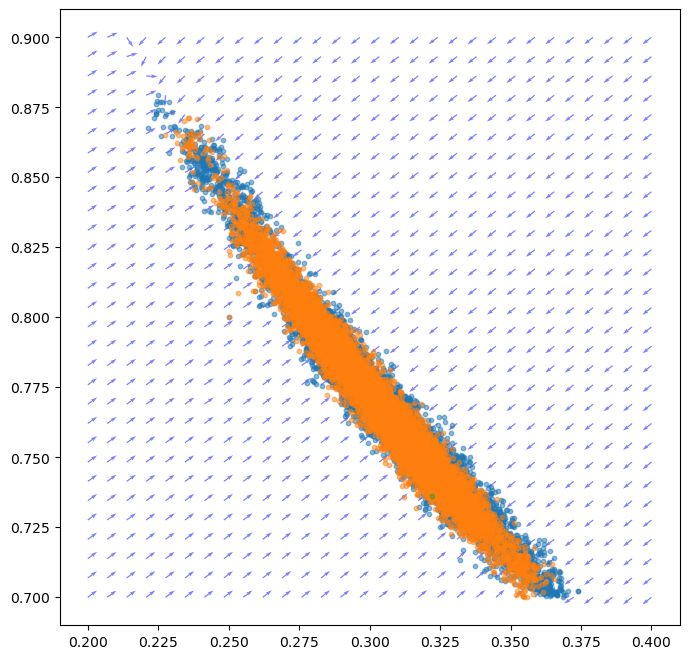

In [155]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range_x = all_prior[0]
plot_range_y = all_prior[1]
norm_vector = True


ax = plot_vector_field(plot_range_x,plot_range_y,
                  lambda theta: fm_regressor.cond_predict(x_fid,theta)*norm,
                  num_points=30,ax=ax,color='blue',alpha=0.5, label='regressor', width=0.002,norm_vector=norm_vector)

ax.scatter(
    samples[:, 0], samples[:, 1], label='FM prediction', alpha=0.5, s=10
)

ax.scatter(
    samples_truth[:, 0], samples_truth[:, 1], label='FM prediction', alpha=0.5, s=10
)

ax.scatter(
    theta_fid[0], theta_fid[1], label='theta_fid', alpha=0.5, s=10
)

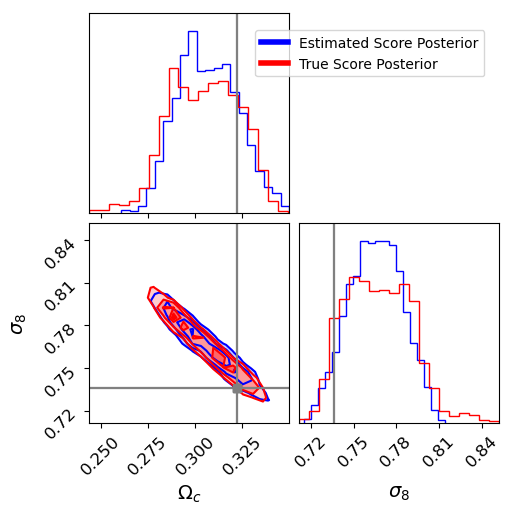

In [157]:
from corner import corner
burn_in = 5000

# fig,ax = plt.subplots(1,1,figsize=(8,8))
fig = corner(samples[burn_in:], 
             truth_color="black",
             truths=theta_fid, color='blue',
             labels=['$\\Omega_c$', '$\\sigma_8$'], 
             hist_kwargs={'density': True},plot_datapoints=False,label='Posterior with Estimated Score',
             fill_contours=True,figsize=(8,8))
from corner import corner
fig = corner(samples_truth[burn_in:], 
             truths=theta_fid,
             truth_color="gray",
             labels=['$\\Omega_c$', '$\\sigma_8$'], color='red', label='Posterior with True Score',
             hist_kwargs={'density': True},plot_datapoints=False,
             fill_contours=True,fig=fig)
legend_handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Estimated Score Posterior'),
                     plt.Line2D([0], [0], color='red', lw=4, label='True Score Posterior')]
fig.legend(handles=legend_handles, loc=(0.50,0.85), fontsize=10)

#set fontsize of labels
for ax in fig.get_axes():
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
